In [27]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
import sklearn.svm as svm
import pandas as pd
import warnings

In [28]:
from featureExtraction import *
from dataAnalyzer import *
from private_tool import *
from dataHandler import *

In [29]:
warnings.filterwarnings('ignore')

In [53]:
experimentNum = 9
experimentIdx = 2
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [54]:
channels = [7, 8, 9, 11] #list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [55]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(4, 4)

In [56]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=7, 
                                                                cutoff_high=30)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [57]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key: np.array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# i: experiment
# j: trial

In [58]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [59]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [60]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [61]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [62]:
len(CSP_passed_left_data)

4

In [63]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [64]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]
np.array(CSP_passed_left_data).shape

(4, 49, 1875)

In [65]:
CSP_passed_left_data = np.array([i.T for i in np.array(CSP_passed_left_data).T]).T
CSP_passed_right_data = np.array([i.T for i in np.array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = np.array([i.T for i in np.array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = np.array([i.T for i in np.array(CSP_passed_foot_data).T]).T
CSP_passed_left_data.shape

(49, 4, 1875)

In [66]:
m = 3

leftVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_left_data, 0, channelNum, minTrialsNum, m)
rightVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_right_data, 1, channelNum, minTrialsNum, m)
tongueVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_tongue_data, 2, channelNum, minTrialsNum, m)
footVarRatioDF = twoTimesMDimensionalFeature(CSP_passed_foot_data, 3, channelNum, minTrialsNum, m)

VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-1.350333,-1.350333,-1.350333,-1.350333,-1.350333,-1.350333,0
1,-1.376057,-1.376057,-1.376057,-1.376057,-1.376057,-1.376057,0
2,-1.433347,-1.433347,-1.433347,-1.433347,-1.433347,-1.433347,0
3,-1.434852,-1.434852,-1.434852,-1.434852,-1.434852,-1.434852,0
4,-1.434313,-1.434313,-1.434313,-1.434313,-1.434313,-1.434313,0
...,...,...,...,...,...,...,...
191,-1.443443,-1.443443,-1.443443,-1.443443,-1.443443,-1.443443,3
192,-1.472139,-1.472139,-1.472139,-1.472139,-1.472139,-1.472139,3
193,-1.310294,-1.310294,-1.310294,-1.310294,-1.310294,-1.310294,3
194,-1.307843,-1.307843,-1.307843,-1.307843,-1.307843,-1.307843,3


In [67]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,0.740093,0.740093,0.740093,0.740093,0.740093,0.740093
1,0.395173,0.395173,0.395173,0.395173,0.395173,0.395173
2,-0.373000,-0.373000,-0.373000,-0.373000,-0.373000,-0.373000
3,-0.393173,-0.393173,-0.393173,-0.393173,-0.393173,-0.393173
4,-0.385951,-0.385951,-0.385951,-0.385951,-0.385951,-0.385951
...,...,...,...,...,...,...
191,-0.508370,-0.508370,-0.508370,-0.508370,-0.508370,-0.508370
192,-0.893136,-0.893136,-0.893136,-0.893136,-0.893136,-0.893136
193,1.276952,1.276952,1.276952,1.276952,1.276952,1.276952
194,1.309814,1.309814,1.309814,1.309814,1.309814,1.309814


In [68]:
n_componunts = 5
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [69]:
sum(PCA.explained_variance_ratio_())

1.0

In [70]:
# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증
scores = cross_val_score(svm_clf, principalDF, labelDF, cv = 5)

print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
svm_clf = svm.SVC(kernel = 'rbf')

# 교차검증
scores = cross_val_score(svm_clf, principalDF, labelDF, cv = 5)

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.4796153846153846
교차검증 평균:  0.4441025641025641


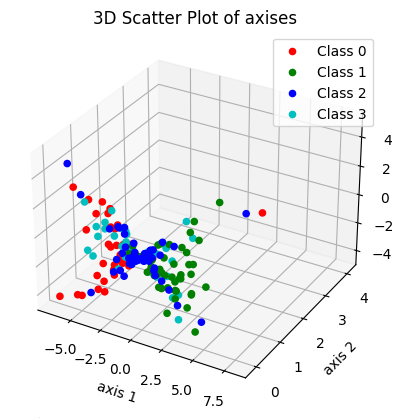

,axis1,axis2,axis3,axis4,axis5,label
0,1.812850,4.115107e-15,-2.623297e-17,1.240070e-45,4.009956e-52,0
1,0.967972,-1.361474e-18,1.888402e-18,1.576912e-30,-2.003113e-37,0
2,-0.913659,3.483343e-19,-2.143602e-18,3.338700e-33,1.125397e-35,0
3,-0.963073,2.214898e-17,6.138381e-18,5.271792e-33,3.751807e-35,0
4,-0.945382,-1.424753e-17,-7.850092e-18,4.238156e-33,2.575125e-37,0
...,...,...,...,...,...,...
191,-1.245246,7.077673e-19,-2.831725e-18,1.252600e-32,-3.058419e-37,3
192,-2.187726,3.623039e-17,8.514170e-18,1.073010e-32,-3.530861e-37,3
193,3.127881,-6.277305e-17,-1.640366e-17,-2.054313e-33,-2.035435e-37,3
194,3.208375,-1.050715e-16,-3.251105e-17,-1.607375e-32,-1.456756e-36,3


In [71]:
df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(data=df, num_of_classes=4)
df

In [78]:
np.save(currDir+"/test.npy", df)

In [72]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(principalDF, labelDF, 3, "eigen")), labelDF], axis=1)

In [73]:
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

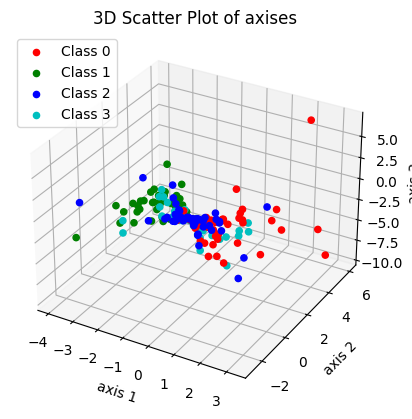

,axis1,axis2,axis3,axis4,axis5,label
0,1.812850,4.115107e-15,-2.623297e-17,1.240070e-45,4.009956e-52,0
1,0.967972,-1.361474e-18,1.888402e-18,1.576912e-30,-2.003113e-37,0
2,-0.913659,3.483343e-19,-2.143602e-18,3.338700e-33,1.125397e-35,0
3,-0.963073,2.214898e-17,6.138381e-18,5.271792e-33,3.751807e-35,0
4,-0.945382,-1.424753e-17,-7.850092e-18,4.238156e-33,2.575125e-37,0
...,...,...,...,...,...,...
191,-1.245246,7.077673e-19,-2.831725e-18,1.252600e-32,-3.058419e-37,3
192,-2.187726,3.623039e-17,8.514170e-18,1.073010e-32,-3.530861e-37,3
193,3.127881,-6.277305e-17,-1.640366e-17,-2.054313e-33,-2.035435e-37,3
194,3.208375,-1.050715e-16,-3.251105e-17,-1.607375e-32,-1.456756e-36,3


In [79]:
# df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(data=LDA_DF, num_of_classes=4)
df

In [80]:
np.save(currDir+"/test.npy", LDA_DF)

In [74]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [75]:
# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)
print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
svm_clf = svm.SVC(kernel = 'rbf')

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.47923076923076924
교차검증 평균:  0.428974358974359
